In [ ]:
!pip install pytorch-metric-learning
!pip install faiss-cpu

In [4]:
!curl -L -o ./face-recognition-dataset.zip https://www.kaggle.com/api/v1/datasets/download/vasukipatel/face-recognition-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  725M  100  725M    0     0  72.5M      0  0:00:10  0:00:10 --:--:-- 47.2M


In [ ]:
!unzip ./face-recognition-dataset.zip

In [85]:
from tqdm import tqdm
import torch
from torchvision import models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pytorch_metric_learning.utils.inference import InferenceModel, MatchFinder, CosineSimilarity
import torch.optim as optim
from pytorch_metric_learning import losses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [7]:
from torch.utils.data import Dataset
from PIL import Image
import os
import torch
import pandas as pd

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.label_map = self._create_label_map()

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label_str = self.img_labels.iloc[idx, 1]
        # label = torch.tensor(self.label_map[label_str])
        label = self.label_map[label_str]


        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def _create_label_map(self):
        unique_labels = self.img_labels.iloc[:, 1].unique()
        return {label: i for i, label in enumerate(unique_labels)}

    def get_label_map(self):
        return self.label_map

In [8]:
N_CLASSES = 31

In [9]:
from pytorch_metric_learning.losses import ArcFaceLoss

loss_func = ArcFaceLoss(num_classes=N_CLASSES, embedding_size=128) # resnet18


In [11]:
labels_df = pd.read_csv('./Dataset.csv')

data_dir = './Faces/Faces'

transform = models.ResNet18_Weights.IMAGENET1K_V1.transforms()

image_dataset = CustomImageDataset(annotations_file=labels_df, img_dir=data_dir, transform=transform)

# Save the label mapping
label_map = image_dataset.get_label_map()
import json
with open('label_map.json', 'w') as f:
    json.dump(label_map, f)

dataloader = DataLoader(image_dataset, batch_size=32, shuffle=True)

In [12]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [13]:
model = torch.nn.Sequential(
    *(list(model.children())[:-1]),
    torch.nn.Flatten(),
    torch.nn.Linear(512, 128),  # learnable embedding layer
    torch.nn.BatchNorm1d(128),   # often improves metric learning
)

In [ ]:
model

In [15]:
device = torch.device('cuda')
model = model.to(device)

In [16]:
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [17]:
model.train()
for epoch in range(50):
	for i, (data, labels) in tqdm(enumerate(dataloader)):
		data, labels = data.to(device), labels.to(device)
		optimizer.zero_grad()
		embeddings = model(data)
		loss = loss_func(embeddings, labels)
		loss.backward()
		optimizer.step()
	print(f'Epoch {epoch+1}, Loss: {loss.item()}')


81it [00:13,  6.09it/s]


Epoch 1, Loss: 39.02741622924805


81it [00:10,  7.45it/s]


Epoch 2, Loss: 35.68156433105469


81it [00:10,  7.46it/s]


Epoch 3, Loss: 44.83753967285156


81it [00:10,  7.63it/s]


Epoch 4, Loss: 34.513893127441406


81it [00:10,  7.55it/s]


Epoch 5, Loss: 38.24782180786133


81it [00:11,  7.32it/s]


Epoch 6, Loss: 37.681705474853516


81it [00:11,  6.91it/s]


Epoch 7, Loss: 41.38435363769531


81it [00:11,  7.32it/s]


Epoch 8, Loss: 33.71158981323242


81it [00:10,  7.40it/s]


Epoch 9, Loss: 24.61015510559082


81it [00:10,  7.41it/s]


Epoch 10, Loss: 26.744190216064453


81it [00:10,  7.38it/s]


Epoch 11, Loss: 37.90643310546875


81it [00:11,  7.26it/s]


Epoch 12, Loss: 27.768314361572266


81it [00:10,  7.41it/s]


Epoch 13, Loss: 23.478824615478516


81it [00:10,  7.60it/s]


Epoch 14, Loss: 25.57831382751465


81it [00:10,  7.58it/s]


Epoch 15, Loss: 27.400793075561523


81it [00:11,  7.35it/s]


Epoch 16, Loss: 30.725418090820312


81it [00:10,  7.53it/s]


Epoch 17, Loss: 39.53455352783203


81it [00:10,  7.47it/s]


Epoch 18, Loss: 22.770122528076172


81it [00:10,  7.45it/s]


Epoch 19, Loss: 31.07857894897461


81it [00:10,  7.45it/s]


Epoch 20, Loss: 27.019851684570312


81it [00:10,  7.42it/s]


Epoch 21, Loss: 35.321842193603516


81it [00:11,  7.26it/s]


Epoch 22, Loss: 26.39270782470703


81it [00:11,  7.28it/s]


Epoch 23, Loss: 29.764663696289062


81it [00:10,  7.87it/s]


Epoch 24, Loss: 20.48446273803711


81it [00:10,  7.52it/s]


Epoch 25, Loss: 21.982311248779297


81it [00:10,  7.41it/s]


Epoch 26, Loss: 22.288063049316406


81it [00:10,  7.39it/s]


Epoch 27, Loss: 18.718917846679688


81it [00:11,  7.36it/s]


Epoch 28, Loss: 36.05265808105469


81it [00:10,  7.42it/s]


Epoch 29, Loss: 25.914634704589844


81it [00:11,  7.02it/s]


Epoch 30, Loss: 22.895118713378906


81it [00:10,  7.38it/s]


Epoch 31, Loss: 20.358064651489258


81it [00:10,  7.37it/s]


Epoch 32, Loss: 27.29525375366211


81it [00:10,  7.42it/s]


Epoch 33, Loss: 23.909950256347656


81it [00:10,  7.70it/s]


Epoch 34, Loss: 24.34265899658203


81it [00:10,  7.60it/s]


Epoch 35, Loss: 19.512372970581055


81it [00:11,  7.35it/s]


Epoch 36, Loss: 24.01428985595703


81it [00:11,  7.30it/s]


Epoch 37, Loss: 49.17042541503906


81it [00:11,  6.90it/s]


Epoch 38, Loss: 25.323665618896484


81it [00:11,  7.25it/s]


Epoch 39, Loss: 24.894939422607422


81it [00:11,  7.25it/s]


Epoch 40, Loss: 45.897056579589844


81it [00:11,  7.24it/s]


Epoch 41, Loss: 46.511253356933594


81it [00:11,  7.24it/s]


Epoch 42, Loss: 16.06048583984375


81it [00:11,  7.33it/s]


Epoch 43, Loss: 22.226688385009766


81it [00:10,  7.37it/s]


Epoch 44, Loss: 24.549522399902344


81it [00:10,  7.40it/s]


Epoch 45, Loss: 24.597938537597656


81it [00:10,  7.50it/s]


Epoch 46, Loss: 21.842214584350586


81it [00:11,  7.30it/s]


Epoch 47, Loss: 28.341686248779297


81it [00:11,  7.27it/s]


Epoch 48, Loss: 19.356937408447266


81it [00:11,  7.30it/s]


Epoch 49, Loss: 31.72617530822754


81it [00:10,  7.38it/s]

Epoch 50, Loss: 30.41015625


In [18]:
torch.save(model.state_dict(), 'face_recognition_model_weights_resnet18_epoch50_fc.pth')

In [37]:
model.load_state_dict(torch.load('face_recognition_model_weights_resnet18_epoch50_fc.pth'))

<All keys matched successfully>

In [67]:
model.eval()
InferenceModel(model,
                embedder=None,
                match_finder=MatchFinder(distance=CosineSimilarity(), threshold=0.9),
                normalize_embeddings=True,
                knn_func=None,
                data_device=None,
                dtype=None)

In [68]:
# initialize with a model
im = InferenceModel(model)

# pass in a dataset to serve as the search space for k-nn
im.train_knn(image_dataset)

In [40]:
len(image_dataset)

2562

In [69]:
def inverse_transform(img_tensor):
    # Inverse normalization for ImageNet
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor.clone().cpu()
    img = img * std + mean
    img = img.clamp(0, 1)
    return img

In [70]:
QUERY_INDEX = 0

# Inference for Original Query

In [90]:
N_NEIGHBOR = 30

In [91]:
# Load the query image
query = image_dataset[QUERY_INDEX][0]
query = query.unsqueeze(0)

# get the 10 nearest neighbors of a query
distances, indices = im.get_nearest_neighbors(query, k=N_NEIGHBOR)

In [75]:
def get_matches_stats(indices):
    # Get the true label of the query image
    query_label = image_dataset[QUERY_INDEX][1]
    print("Query label: ", query_label)

    # Initialize a counter for correct matches
    correct_matches = 0

    neighbor_labels = []

    # Iterate through the indices of the nearest neighbors
    for idx in indices[0].tolist():
        # Get the true label of the neighbor image
        neighbor_label = image_dataset[idx][1]
        neighbor_labels.append(neighbor_label)

        # Compare the neighbor's label with the query label
        if neighbor_label == query_label:
            correct_matches += 1

    print("Neighbor labels: ", neighbor_labels)
    print("Neighbors : ", N_NEIGHBOR ,"Correct matches: ", correct_matches)

    # Calculate the percentage of correct matches
    percentage_correct = (correct_matches / len(indices[0])) * 100

    print(f"Percentage of correct matches in the 30 nearest neighbors: {percentage_correct:.2f}%")

def calc_distances_stats(distances):
    # Calculate MSE of distances
    mse = torch.mean(distances**2)
    print(f"MSE of distances: {mse.item()}")

    # Calculate Cosine similarity
    cosine_similarity = 1 - distances
    print(f"Cosine similarity: {cosine_similarity.mean().item()}")

In [76]:
get_matches_stats(indices)

Query label:  0
Neighbor labels:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Neighbors :  30 Correct matches:  30
Percentage of correct matches in the 30 nearest neighbors: 100.00%


In [77]:
calc_distances_stats(distances)

MSE of distances: 0.3970901072025299
Cosine similarity: 0.38180142641067505


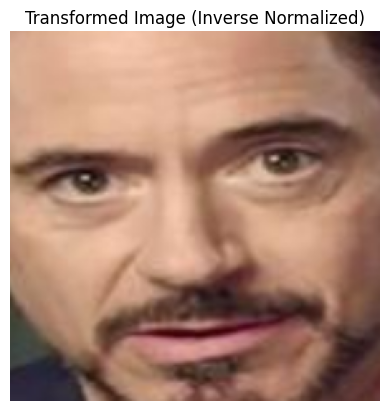

In [92]:
img_tensor = image_dataset[QUERY_INDEX][0]
img = inverse_transform(img_tensor).permute(1, 2, 0).numpy()

plt.imshow(img)
plt.title("Transformed Image (Inverse Normalized)")
plt.axis('off')
plt.show()

In [93]:
def plot_neighbors(indices):
    fig, axes = plt.subplots(6, 5, figsize=(15, 16))
    axes = axes.flatten()

    for idx, ax in zip(indices[0].tolist(), axes):
        img_tensor = image_dataset[idx][0]
        img = inverse_transform(img_tensor).permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Index: {idx}')

    plt.tight_layout()
    plt.show()

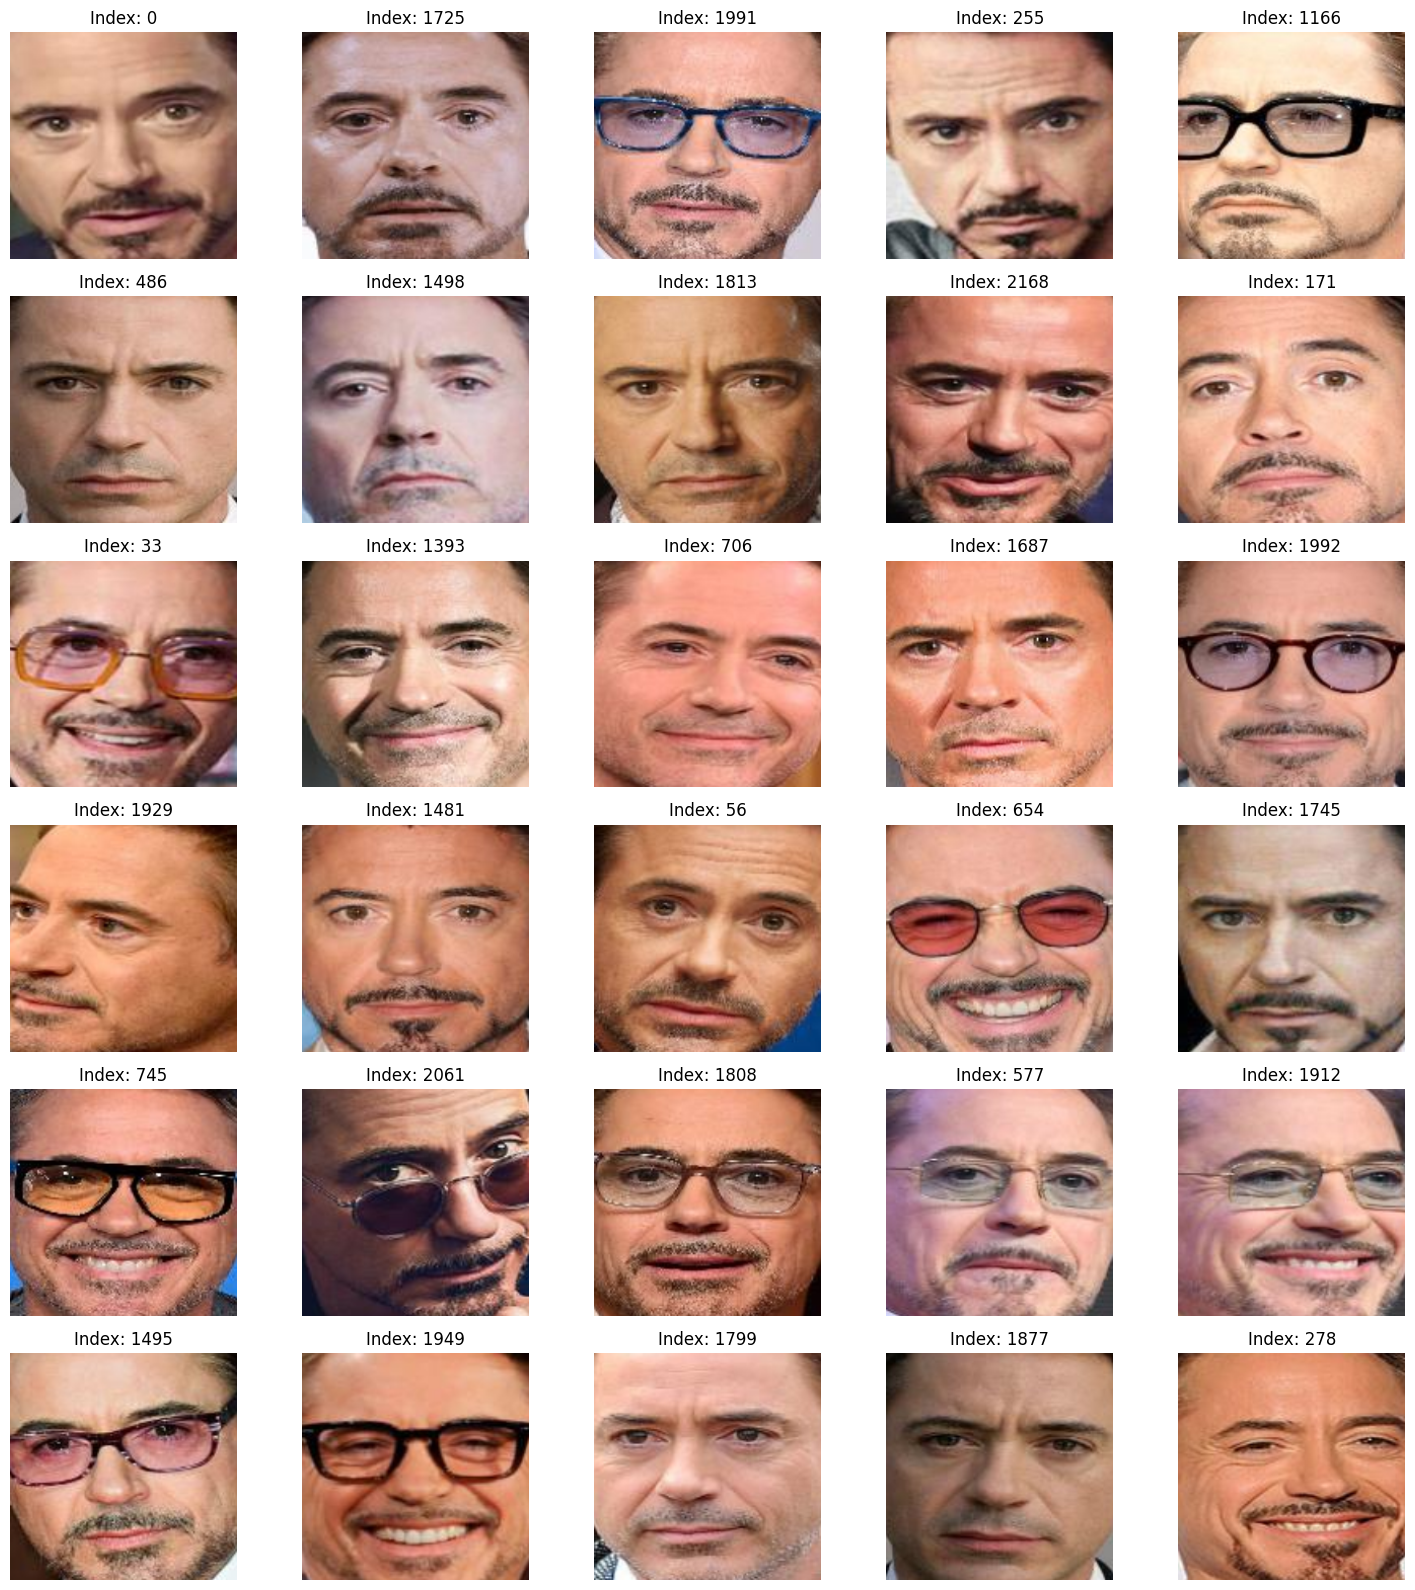

In [94]:
plot_neighbors(indices)

In [118]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [127]:
labels_og_adv

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 11, 10, 12, 13, 14,
        8, 15, 16,  2, 17, 12,  1,  8,  1, 11, 10, 13, 15, 18, 16, 19,  0,
       12, 20,  7, 21, 14, 17,  5,  2, 22,  5, 20,  4, 23, 23,  4, 17, 22,
       24, 10,  9, 17,  8,  0, 14,  2, 25, 15, 26, 27, 17,  4, 11,  4, 24,
       26, 20, 27,  6, 26, 24, 22,  7, 16, 27, 18, 14,  4, 18, 28, 25, 15,
       16,  3, 19, 15, 16, 12,  9, 27,  4, 16, 12, 11,  4,  4,  1])

In [131]:
N_QUERIES = 100

def get_query_stats(query_index):
    average_correct_matches_percentage = 0

    # Select 100 random indices as queries
    query_indices = random.sample(range(len(image_dataset)), N_QUERIES)

    all_percentages = []

    for query_index in tqdm(query_indices):
        # Load the query image
        query = image_dataset[query_index][0]
        query = query.unsqueeze(0)

        # get the 30 nearest neighbors of a query
        distances, indices = im.get_nearest_neighbors(query, k=N_NEIGHBOR)

        # Get the true label of the query image
        query_label = image_dataset[query_index][1]

        # Initialize a counter for correct matches
        correct_matches = 0

        # Iterate through the indices of the nearest neighbors
        for idx in indices[0].tolist():
            # Get the true label of the neighbor image
            neighbor_label = image_dataset[idx][1]

            # Compare the neighbor's label with the query label
            if neighbor_label == query_label:
                correct_matches += 1

        # Calculate the percentage of correct matches
        percentage_correct = (correct_matches / len(indices[0])) * 100
        all_percentages.append(percentage_correct)


    # Calculate the average percentage of correct matches
    average_correct_matches_percentage = sum(all_percentages) / len(all_percentages)

    print(f"\nAverage percentage of correct matches over {N_QUERIES} queries: {average_correct_matches_percentage:.2f}%")

In [132]:
get_query_stats(query_index)

100%|██████████| 100/100 [00:09<00:00, 10.99it/s]


Average percentage of correct matches over 100 queries: 100.00%


# Inference for PGD

In [ ]:
!unzip ./faceadv_pgd.zip

In [122]:
def get_adv_neighbors(adv_img_np):
    # Convert to torch tensor and add batch dimension if needed
    adv_img_tensor = torch.tensor(adv_img_np, dtype=torch.float32)
    if adv_img_tensor.ndim == 3:
        adv_img_tensor = adv_img_tensor.unsqueeze(0)

    # Move to the correct device
    adv_img_tensor = adv_img_tensor.to(device)

    # Get the 30 nearest neighbors using the adversarial image as query
    distances, indices = im.get_nearest_neighbors(adv_img_tensor, k=N_NEIGHBOR)

    return distances, indices, adv_img_tensor

In [142]:
# Load the adversarial image from .npy file
adv_img_np = np.load('./FacesAdv_PGD/adv_np/00000.npy') # PGD

distances, indices, query_adv_img_tensor = get_adv_neighbors(adv_img_np)

In [143]:
get_matches_stats(indices)

Query label:  0
Neighbor labels:  [24, 24, 24, 21, 24, 24, 19, 9, 24, 3, 24, 10, 24, 9, 24, 21, 10, 24, 24, 21, 21, 3, 24, 24, 3, 18, 3, 21, 3, 9]
Neighbors :  30 Correct matches:  0
Percentage of correct matches in the 30 nearest neighbors: 0.00%


In [144]:
calc_distances_stats(distances)

MSE of distances: 1.8715484142303467
Cosine similarity: -0.3663507103919983


In [124]:
get_query_stats(query_index)

100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


Average percentage of correct matches over 100 queries: 100.00%


In [152]:
N_ADV_IMAGES = 100

def get_adv_query_stats(adv_path):
    all_percentages_adv_pgd = []

    labels_og_adv = np.load(f'{adv_path}/labels_og_adv.npy')

    for i in tqdm(range(N_ADV_IMAGES)):
        # Construct the file path
        img_path = f'{adv_path}/adv_np/{i:05d}.npy'

        # Load the adversarial image
        adv_img_np = np.load(img_path)

        # Get the ground truth label from labels_og_adv
        query_label = labels_og_adv[i]

        # Get the nearest neighbors for the adversarial image
        distances, indices, _ = get_adv_neighbors(adv_img_np)

        # Initialize a counter for correct matches
        correct_matches = 0

        # Iterate through the indices of the nearest neighbors
        for idx in indices[0].tolist():
            # Get the true label of the neighbor image
            neighbor_label = image_dataset[idx][1]

            # Compare the neighbor's label with the query label
            if neighbor_label == query_label:
                correct_matches += 1

        # Calculate the percentage of correct matches
        percentage_correct = (correct_matches / len(indices[0])) * 100
        all_percentages_adv_pgd.append(percentage_correct)

    # Calculate the average percentage of correct matches
    average_correct_matches_percentage_adv_pgd = sum(all_percentages_adv_pgd) / len(all_percentages_adv_pgd)

    print(f"\nAverage percentage of correct matches over {N_ADV_IMAGES} adversarial queries: {average_correct_matches_percentage_adv_pgd:.2f}%")

In [147]:
ADV_PGD_PATH = './FacesAdv_PGD'

get_adv_query_stats(ADV_PGD_PATH)

100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


Average percentage of correct matches over 100 adversarial queries: 25.80%


In [104]:
def plot_adv_query(query_adv_img_tensor):
    # Remove batch dimension if present
    adv_img = adv_img_tensor.squeeze().detach().cpu()
    # Inverse normalize
    adv_img_vis = inverse_transform(adv_img).permute(1, 2, 0).numpy()

    plt.imshow(adv_img_vis)
    plt.title("Adversarial Image (Inverse Normalized)")
    plt.axis('off')
    plt.show()

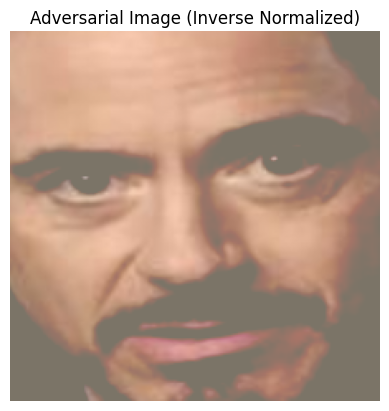

In [105]:
plot_adv_query(query_adv_img_tensor)

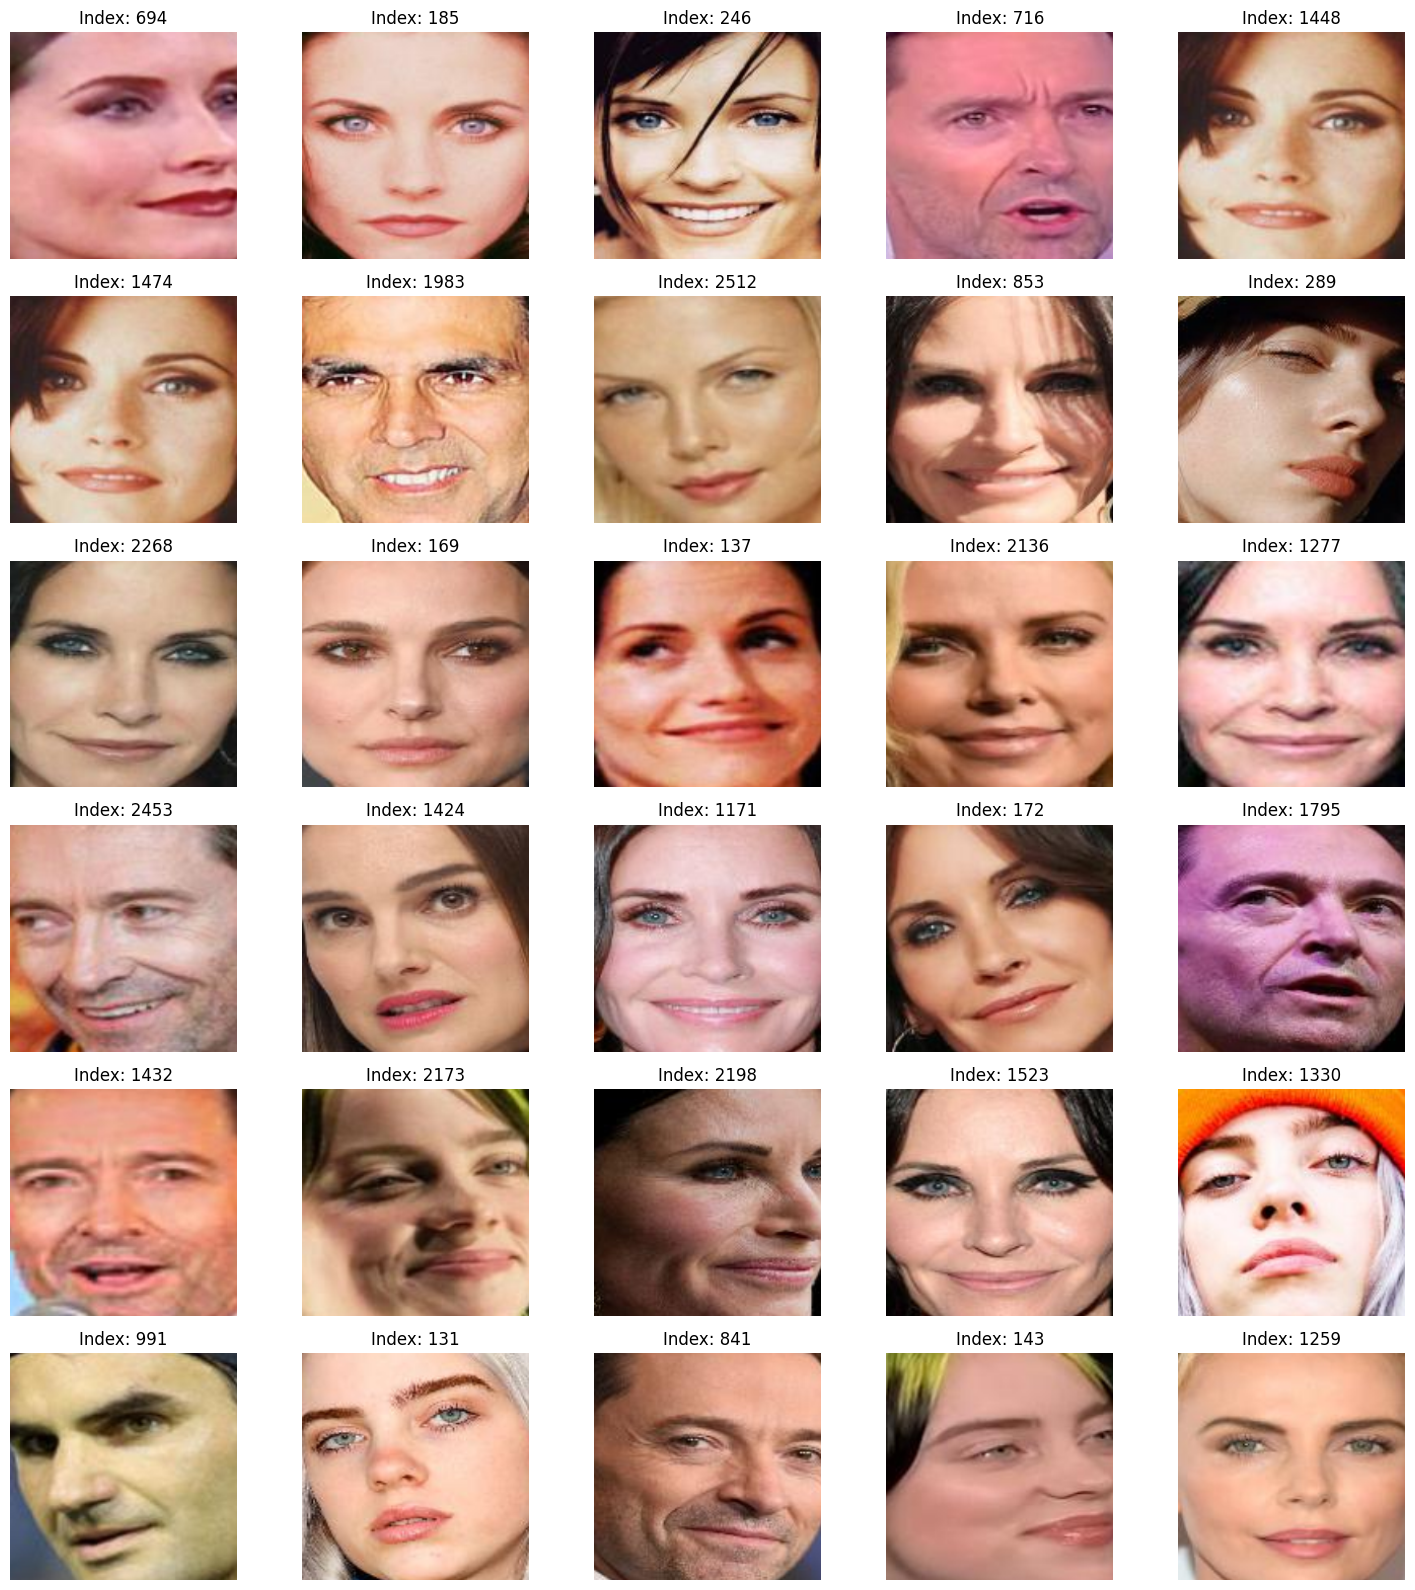

In [106]:
plot_neighbors(indices)

# Inference for Adversarial Query ( Carlini L2 )

In [ ]:
!unzip ./faceadv_carlini.zip

In [140]:
# Load the adversarial image from .npy file
adv_img_np = np.load('./FacesAdv_Carlini/adv_np/00000.npy') # Carlini L2

distances, indices, query_adv_img_tensor = get_adv_neighbors(adv_img_np)

In [108]:
get_matches_stats(indices)

Query label:  0
Neighbor labels:  [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
Neighbors :  30 Correct matches:  0
Percentage of correct matches in the 30 nearest neighbors: 0.00%


In [109]:
calc_distances_stats(distances)

MSE of distances: 1.560073733329773
Cosine similarity: -0.24740272760391235


In [137]:
# 1 Query
get_query_stats(query_index)

100%|██████████| 100/100 [00:09<00:00, 10.85it/s]


Average percentage of correct matches over 100 queries: 99.83%


In [153]:
ADV_CARLINI_PATH = './FacesAdv_Carlini'

# 100 Query mean
get_adv_query_stats(ADV_CARLINI_PATH)

100%|██████████| 100/100 [00:08<00:00, 11.67it/s]


Average percentage of correct matches over 100 adversarial queries: 59.07%


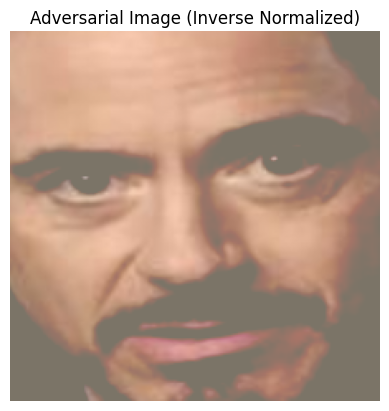

In [110]:
plot_adv_query(query_adv_img_tensor)

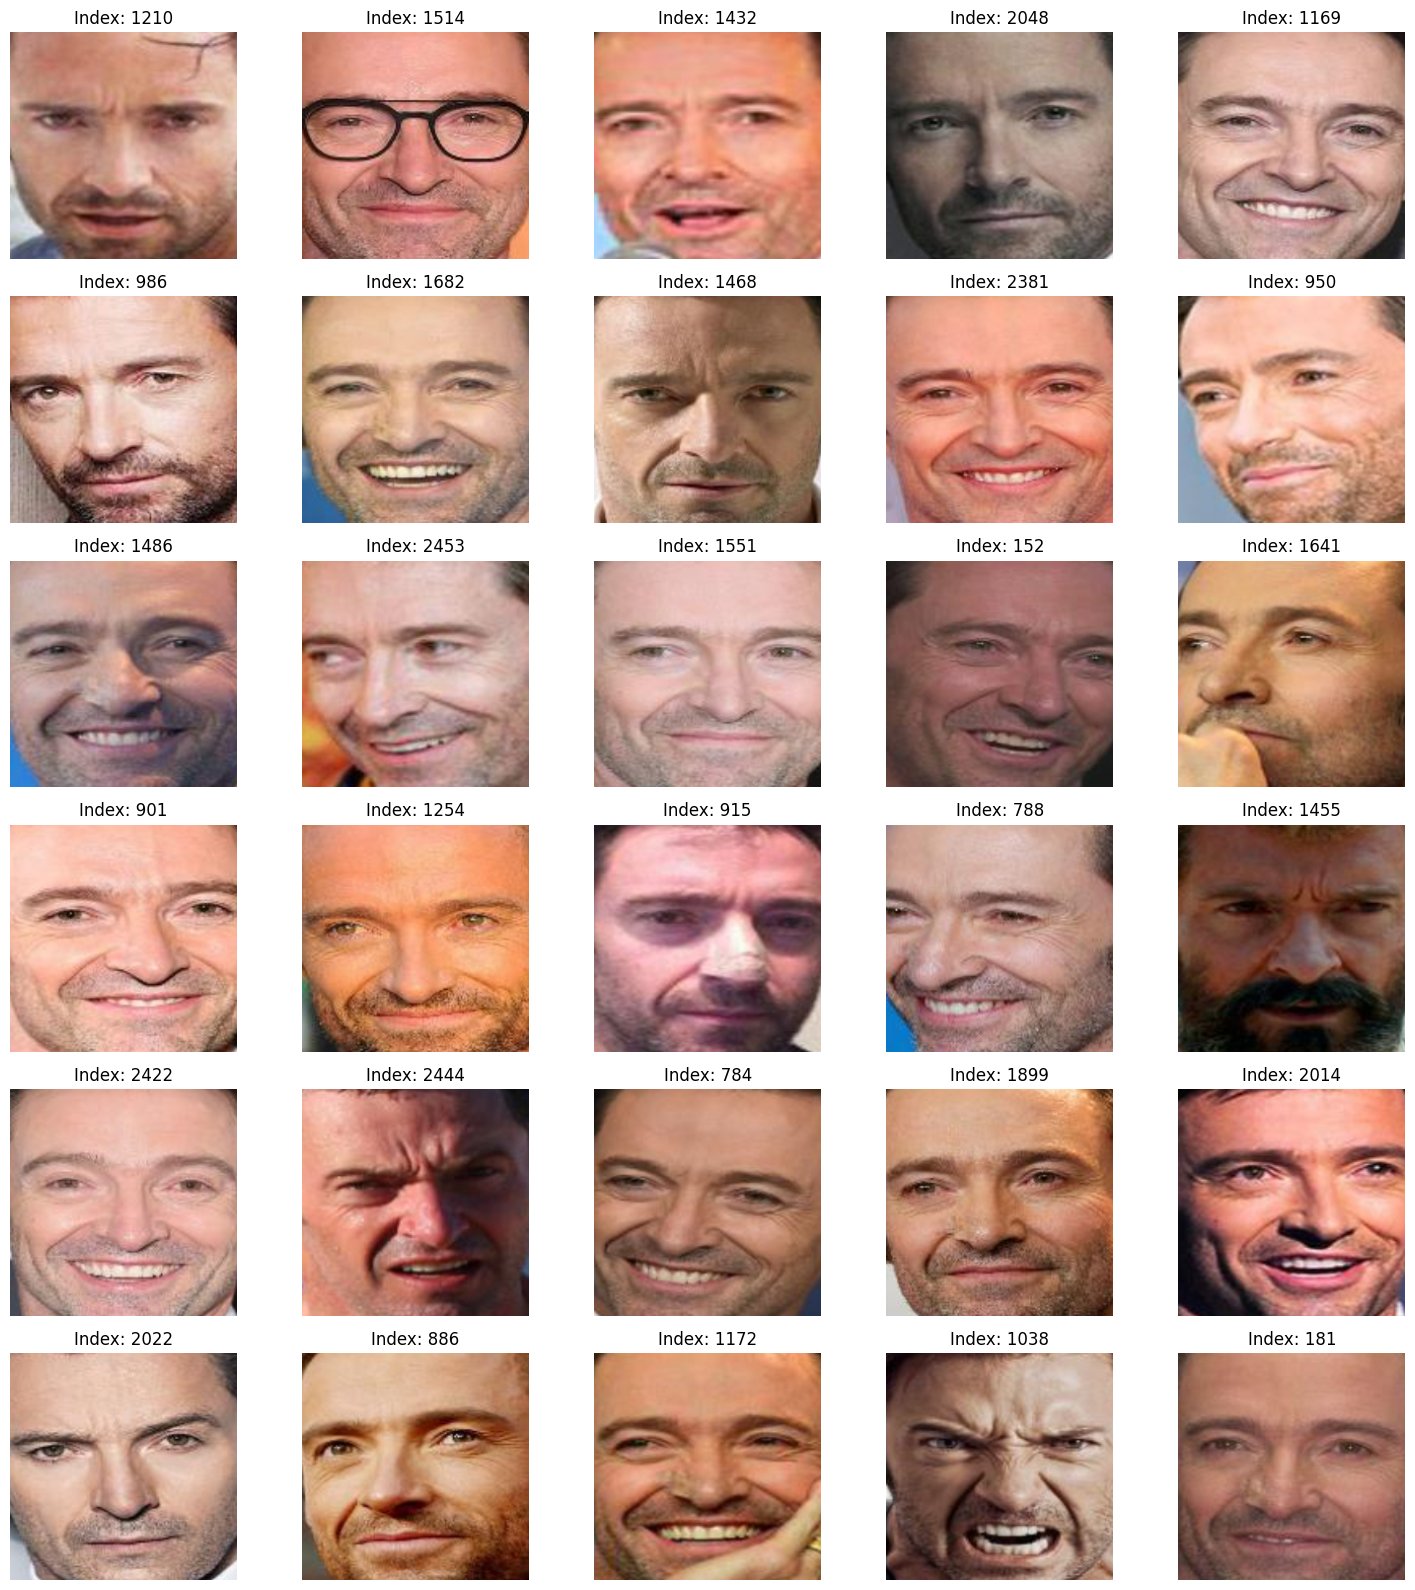

In [111]:
plot_neighbors(indices)